In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Install the 'timm' library for working with pre-trained models and 'faiss-gpu' for GPU-accelerated similarity search.

!pip install timm faiss-gpu


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.6 MB/s eta 0:00:00


In [3]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
import timm # Import timm for working with pre-trained models
import os
import torch
import torch.nn as nn # Import PyTorch's neural network module
import torch.nn.functional as F  # Import PyTorch's functional module for various operations
import torch.optim as optim  # Import PyTorch's optimization algorithms
from torchvision import transforms, datasets  # Import torchvision for image-related operations
from torch.utils.data import DataLoader  # Import DataLoader for loading datasets efficiently
import torchvision  # Import torchvision for computer vision tasks
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler # Import learning rate scheduler from PyTorch
import copy   # Import copy module for creating deep copies of objects


In [4]:
!unzip '/content/drive/MyDrive/DL Labs/dataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: emirhan_human_dataset/datasets/human_data/train_data/running/images_099.jpg  
  inflating: emirhan_human_dataset/datasets/human_data/train_data/running/images_100.jpg  
  inflating: emirhan_human_dataset/datasets/human_data/train_data/running/images_101 (2).jpg  
  inflating: emirhan_human_dataset/datasets/human_data/train_data/running/images_101.jpg  
  inflating: emirhan_human_dataset/datasets/human_data/train_data/running/images_102 (2).jpg  
  inflating: emirhan_human_dataset/datasets/human_data/train_data/running/images_102.jpg  
  inflating: emirhan_human_dataset/datasets/human_data/train_data/running/images_103 (2).jpg  
  inflating: emirhan_human_dataset/datasets/human_data/train_data/running/images_103.jpg  
  inflating: emirhan_human_dataset/datasets/human_data/train_data/running/images_104 (2).jpg  
  inflating: emirhan_human_dataset/datasets/human_data/train_data/running/images_104 (3).jpg  
  inflating: emirha

In [6]:
# Just normalization for validation
data_transforms = {
    'train_data': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test_data': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '../content/emirhan_human_dataset/datasets/human_data/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train_data', 'test_data']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train_data', 'test_data']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train_data', 'test_data']}
class_names = image_datasets['train_data'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


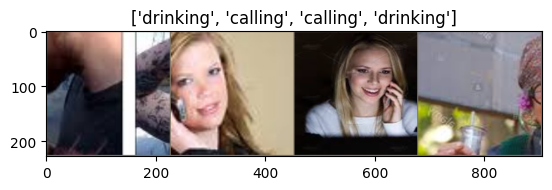

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train_data']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train_data', 'test_data']:
            if phase == 'train_data':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train_data'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train_data':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train_data':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'test_data' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [9]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test_data']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [10]:
model = timm.create_model("tf_efficientnetv2_s_in21ft1k", pretrained=True, drop_rate=0.3, num_classes=len(class_names))

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnetv2_s_in21ft1k to current tf_efficientnetv2_s.in21k_ft_in1k.
  model = create_fn(


In [11]:
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=10)

Epoch 0/9
----------
train_data Loss: 1.9025 Acc: 0.4176
test_data Loss: 0.8979 Acc: 0.7300

Epoch 1/9
----------
train_data Loss: 1.3428 Acc: 0.5841
test_data Loss: 0.7961 Acc: 0.7593

Epoch 2/9
----------
train_data Loss: 1.1868 Acc: 0.6333
test_data Loss: 0.6922 Acc: 0.7790

Epoch 3/9
----------
train_data Loss: 1.0976 Acc: 0.6597
test_data Loss: 0.6903 Acc: 0.7933

Epoch 4/9
----------
train_data Loss: 1.0177 Acc: 0.6815
test_data Loss: 0.6709 Acc: 0.8043

Epoch 5/9
----------
train_data Loss: 0.9617 Acc: 0.7003
test_data Loss: 0.6697 Acc: 0.7927

Epoch 6/9
----------
train_data Loss: 0.9252 Acc: 0.7081
test_data Loss: 0.6435 Acc: 0.8027

Epoch 7/9
----------
train_data Loss: 0.8069 Acc: 0.7455
test_data Loss: 0.5958 Acc: 0.8190

Epoch 8/9
----------
train_data Loss: 0.7815 Acc: 0.7568
test_data Loss: 0.6026 Acc: 0.8183

Epoch 9/9
----------
train_data Loss: 0.7656 Acc: 0.7583
test_data Loss: 0.6042 Acc: 0.8207

Training complete in 58m 39s
Best val Acc: 0.820667


In [19]:

visualize_model(model)

plt.ioff()
plt.show()